# PALM with N terms

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import time
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import misc
from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr

from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.utils.bilinear import LowRankFactorizedMatrix as pyproxLowRankFactorizedMatrix
from pyproximal.optimization.palm import PALM

In [2]:
class MultiFactor():
    def __init__(self, Xs, d, Op=None):        
        self.nx = len(Xs)
        self.xs = Xs
        self.d = d
        self.Op = Op
        
    def __call__(self, xs):
        # write a code that evaluates H(x_0, x_1, ..., x_n)
        pass
    
    def gradx(self, x, ix=0):
        pass
        
    def grad(self, x):
        g = np.hstack([self.gradx(x, ix) for ix, x_ in enumerate(x)])
        return g

    def updatex(self, x, ix):
        """Update x variable (to be used to update one of the internal variables)
        """
        self.xs[ix] = x
        
    def update(self, xs):
        """Update all variables
        """
        for ix, x in enumerate(xs):
            self.updatex(x, ix)
            

class TileLowRankSymmFactorized(MultiFactor):
    def __call__(self, xs):
        # write a code that evaluates H(x_0, x_1, ..., x_n)
        pass
    
    def gradx(self, x, ix=0):
        if ix == 0:
            # write code for grad_x0 H(x, x_1, ...x_n)
            # with x1=self.xs[1], x2=self.xs[2],
            pass
        elif ix == 1:
            # write code for grad_x1 H(x_0, x, ...x_n)
            # with x0=self.xs[0], x2=self.xs[2],
            pass

In [3]:
class LowRankFactorizedMatrix():
    r"""Low-Rank Factorized Matrix operator

    Bilinear operator representing the L2 norm of a Low-Rank Factorized
    Matrix defined as: :math:`H(\mathbf{X}, \mathbf{Y}) =
    \frac{1}{2} \|\mathbf{Op}(\mathbf{X}\mathbf{Y}) - \mathbf{d}\|_2^2`,
    where :math:`\mathbf{X}` is a matrix of size  :math:`n \times k`,
    :math:`\mathbf{Y}` is a matrix of size :math:`k \times m`, and
    :math:`\mathbf{Op}` is a linear operator of size :math:`p \times n`.

    Parameters
    ----------
    Xs : :obj:`list`
        List of matrices, containing 
        i) Left-matrix of size :math:`n \times k`,
        ii) Right-matrix of size :math:`k \times m`
    d : :obj:`numpy.ndarray`
        Data vector
    Op : :obj:`pylops.LinearOperator`, optional
        Linear operator

    """
    def __init__(self, Xs, d, Op=None):
        X, Y = Xs[0], Xs[1]
        self.n, self.k = X.shape
        self.m = Y.shape[1]
        
        self.nx = len(Xs)
        self.xs = [X, Y]
        self.y = Y
        self.d = d
        self.Op = Op
        self.shapes = ((self.n * self.m, self.n * self.k), 
                       (self.n * self.m, self.m * self.k))

    def __call__(self, xs):
        x, y = xs[0], xs[1]
        xold = x.copy()
        self.updatex(x, 0)
        res = self.d - self._matvec(y, 1)
        self.updatex(xold, 0)
        return np.linalg.norm(res)**2 / 2.

    def _matvec(self, x, ix):
        if ix == 0:
            X = x.reshape(self.n, self.k)
            X = X @ self.xs[1].reshape(self.k, self.m)
            if self.Op is not None:
                X = self.Op @ X.ravel()
            return X.ravel()
        else:
            Y = x.reshape(self.k, self.m)
            X = self.xs[0].reshape(self.n, self.k) @ Y
            if self.Op is not None:
                X = self.Op @ X.ravel()
            return X.ravel()

    def matvec(self, x):
        if self.n == self.m:
            raise NotImplementedError('Since n=m, this method'
                                      'cannot distinguish automatically'
                                      'between _matvecx and _matvecy. '
                                      'Explicitely call either of those two methods.')
        if x.size == self.shapex[1]:
            y = self._matvec(x, 0)
        else:
            y = self._matvec(x, 1)
        return y

    def lx(self, x, ix):
        
        if ix == 0:
            Y = x[1].reshape(self.k, self.m)
            # TODO: not clear how to handle Op
            #if self.Op is not None:
            #    Y = self.Op @ X
            return np.linalg.norm(Y @ np.conj(Y).T, 'fro')
        else:
            X = np.conj(x[0].reshape(self.n, self.k))
            # TODO: not clear how to handle Op
            #if self.Op is not None:
            #    Y = self.Op.H @ Y
            return np.linalg.norm(np.conj(X).T @ X, 'fro')
        
    def gradx(self, x, ix=0):
        if ix == 0:
            r = self.d - self._matvec(x, 0)
            if self.Op is not None:
                r = (self.Op.H @ r).reshape(self.n, self.m)
            else:
                r = r.reshape(self.n, self.m)
            g = -r @ np.conj(self.xs[1].reshape(self.k, self.m).T)
            return g.ravel()
        else:
            r = self.d - self._matvec(x, 1)
            if self.Op is not None:
                r = (self.Op.H @ r.ravel()).reshape(self.n, self.m)
            else:
                r = r.reshape(self.n, self.m)
            g = -np.conj(self.xs[0].reshape(self.n, self.k).T) @ r
            return g.ravel()

    def grad(self, x):
        gx = self.gradx(x[:self.n * self.k], 0)
        gy = self.gradx(x[self.n * self.k:], 1)
        g = np.hstack([gx, gy])
        return g

    def updatex(self, x, ix):
        """Update x variable (to be used to update one of the internal variables)
        """
        self.xs[ix] = x
        
    def update(self, xs):
        """Update all variables
        """
        for ix, x in enumerate(xs):
            self.updatex(x, ix)

In [4]:
def grad_test(hop, l0, r0, delta=1e-6):
    misfit = hop([l0, r0])

    gl = hop.gradx(l0, 0)
    gr = hop.gradx(r0, 1)

    delta = 1e-6
    iqn, iqm, iqk = np.random.randint(0, n), np.random.randint(0, m), np.random.randint(0, k)
    r_or_i = np.random.randint(0,2)
    l_or_u = np.random.randint(0,2)

    if 0 == r_or_i: 
        delta1 = delta
        
    else:
        delta1 = delta*1j

    if 0 == l_or_u:    
        l0[iqn, iqk] = l0[iqn, iqk] + delta1    
        grad = gl.reshape(n, k)[iqn, iqk]
    else:
        r0[iqk, iqm] = r0[iqk, iqm] + delta1
        grad = gr.reshape(k,m)[iqk, iqm]      

    misfit_new = hop([l0, r0])
    grad_diff = (misfit_new-misfit)/delta - (grad.real if 0==r_or_i else grad.imag)
    print(f"{(misfit_new-misfit)/delta:.4f}\t-\t{grad.real if 0==r_or_i else grad.imag:.4f}\t-\t{grad_diff:.4f}")

In [5]:
def _backtracking(x, tau, H, proxf, ix, beta=0.5, niterback=10):
    r"""Backtracking

    Line-search algorithm for finding step sizes in proximal algorithms when
    the Lipschitz constant of the operator is unknown (or expensive to
    estimate).

    """
    def ftilde(x, y, f, g, tau, ix):
        xy = x - y[ix]
        return f(y) + np.dot(g, xy) + \
               (1. / (2. * tau)) * np.linalg.norm(xy) ** 2

    iiterback = 0
    grad = H.gradx(x[ix], ix)
    z = [x_.copy() for x_ in x]
    while iiterback < niterback:
        z[ix] = proxf.prox(x[ix] - tau * grad, tau)
        ft = ftilde(z[ix], x, H, grad, tau, ix)
        f = H(z)
        if f <= ft or tau < 1e-12: 
            break
        tau *= beta
        iiterback += 1
    return z[ix], tau


def GeneralizedPALM(H, proxfs, x0s, gammafs, beta=0.5, niter=10, niterback=100, 
                    acceleration=None, callback=None, show=False):
    r"""Proximal Alternating Linearized Minimization with N blocks

    Solves the following minimization problem using the Proximal Alternating
    Linearized Minimization (PALM) algorithm:

    .. math::

        \mathbf{x}\mathbf{,y} = \argmin_{\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N}
        \sum_i f_i(\mathbf{x}_i) + g(\mathbf{y}) + H(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)

    where :math:`f_i(\mathbf{x}_i)` are convex functions that have known 
    proximal operators, and :math:`H(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)` 
    is a smooth function.

    Parameters
    ----------
    H : :obj:`pyproximal.utils.bilinear.Nlinear`
        N-linear function
    proxfs : :obj:`pyproximal.ProxOperator`
        Proximal operators of f functions
    x0s : :obj:`list`
        Initial vectors
    gammafs : :obj:`list`, optional
        List of positive weights for ``H`` functions update. If None, use backtracking
    beta : :obj:`float`, optional
        Backtracking parameter (must be between 0 and 1)
    niter : :obj:`int`, optional
        Number of iterations of iterative scheme
    niterback : :obj:`int`, optional
        Max number of iterations of backtracking
    acceleration : :obj:`str`, optional
        Acceleration (``None``, ``vandenberghe`` or ``fista``)
    callback : :obj:`callable`, optional
        Function with signature (``callback(x)``) to call after each iteration
        where ``x`` and ``y`` are the current model vectors
    show : :obj:`bool`, optional
        Display iterations log

    Returns
    -------
    xs : :obj:`numpy.ndarray`
        Inverted x vectors
    
    """
    if show:
        tstart = time.time()
        msgprox = ''.join(['Proximal operator (f%d): %s\n' for i in range(len(proxfs))])
        msg = 'Generalized PALM algorithm\n' + \
              '---------------------------------------------------------\n' + \
              'Bilinear operator: %s\n' + \
              msgprox + \
              'gammafs = %s\tniter = %d\n'
        print(msg % (type(H), *list(itertools.chain.from_iterable([(i, type(prox)) for i, prox in enumerate(proxfs)])), 
                     str(gammafs), niter))
        head = '   Itn      x[0][0]        ' + ''.join(['f%d      ' % i for i in range(len(proxfs))]) + 'H'
        print(head)
    
    nx = len(x0s)
    
    backtracking = False
    if gammafs is None:
        backtracking = True
        taus = [1., ] * nx

    # initialize model
    t = 1.
    xs = [x_.copy() for x_ in x0s]
    ys = [x_.copy() for x_ in x0s]
    
    # iterate
    for iiter in range(niter):
        for ix in range(nx):
            xold = xs[ix].copy()
            
            # proximal step
            if not backtracking:
                ck = gammafs[ix] * H.lx(ys, ix)
                xs[ix] = ys[ix] - (1. / ck) * H.gradx(ys[ix], ix)
                if proxfs[ix] is not None:
                    xs[ix] = proxfs[ix].prox(xs[ix], 1. / ck)
            else:
                xs[ix], taus[ix] = _backtracking(ys, taus[ix], H,
                                                 proxfs[ix], ix,
                                                 beta=beta, niterback=niterback)
            # update x parameter in H function
            H.updatex(xs[ix].copy(), ix)
            
            # update y
            if acceleration == 'vandenberghe':
                omega = iiter / (iiter + 3)
            elif acceleration == 'fista':
                told = t
                t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
                omega = ((told - 1.) / t)
            else:
                omega = 0

            ys[ix] = xs[ix] + omega * (xs[ix] - xold)
            
        # run callback
        if callback is not None:
            callback(xs)

        if show:
            pfs = [proxfs[ix](xs[ix]) if proxfs[ix] is not None else 0. for ix, x in enumerate(xs)]
            if iiter < 10 or niter - iiter < 10 or iiter % (niter // 10) == 0:
                msg = str('%6g    %5.5e   ' + '%5.2e   ' * len(proxfs) + '%5.5e')  % \
                      (iiter, xs[0][0], *pfs, H(xs))
                print(msg)
    if show:
        print('\nTotal time (s) = %.2f' % (time.time() - tstart))
        print('---------------------------------------------------------\n')
    return xs

In [6]:
# Gradient test test
n, m, k = 100, 90, 10
l0 = np.random.rand(n, k) + np.random.rand(n, k)*1j
r0 = np.random.rand(k, m) + np.random.rand(k, m)*1j

Xin = np.random.normal(0, 1, (n, k)) + 1j * np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m)) + 1j * np.random.normal(0, 1, (k, m))
A = np.random.normal(0, 1, (n, m)) + 1j * np.random.normal(0, 1, (n, m))

hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], A.ravel())

for _ in range(10):
    grad_test(hop, Xin, Yin, delta=1e-6)

409.1896	-	409.1895	-	0.0001
-106.4753	-	-106.4753	-	0.0000
90.0801	-	90.0800	-	0.0001
136.6888	-	136.6887	-	0.0001
213.0677	-	213.0676	-	0.0001
-121.2176	-	-121.2177	-	0.0001
-115.5853	-	-115.5853	-	0.0000
-210.5021	-	-210.5022	-	0.0002
-377.7756	-	-377.7757	-	0.0001
-336.1230	-	-336.1231	-	0.0001


In [7]:
# Create problem 
n, m, k = 100, 90, 10
X = np.random.normal(0, 1, (n, k))
Y = np.random.normal(0, 1, (k, m))
X = sp.ndimage.gaussian_filter(X, 1)
Y = sp.ndimage.gaussian_filter(Y, 1)
A = X @ Y

sub = 0.01
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

hop = LowRankFactorizedMatrix([X.copy(), Y.copy()], Rop @ A.ravel(), Rop)

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = [2, 2]	niter = 500

   Itn      x[0][0]        f0      f1      H
     0    5.99222e-01   3.72e+01   3.20e+01   2.28391e+04
     1    4.99060e-01   2.71e+01   2.16e+01   9.95826e+03
     2    3.71577e-01   1.79e+01   1.40e+01   3.38938e+03
     3    2.48132e-01   1.20e+01   9.73e+00   1.21053e+03
     4    1.51238e-01   8.82e+00   7.52e+00   7.25037e+02
     5    8.70615e-02   7.18e+00   6.39e+00   6.43943e+02
     6    5.23584e-02   6.30e+00   5.81e+00   5.94460e+02
     7    3.97995e-02   5.86e+00   5.58e+00   5.09728e+02
     8    4.18024e-02   5.75e+00   5.61e+00   3.94528e+02
     9    5.28354e-02   5.93e+00   5.86e+00   2.80417e+02
    50    2.16475e-01   7.77e+00   7.51e+00   3.25897e+00
   100    7.05952e-0

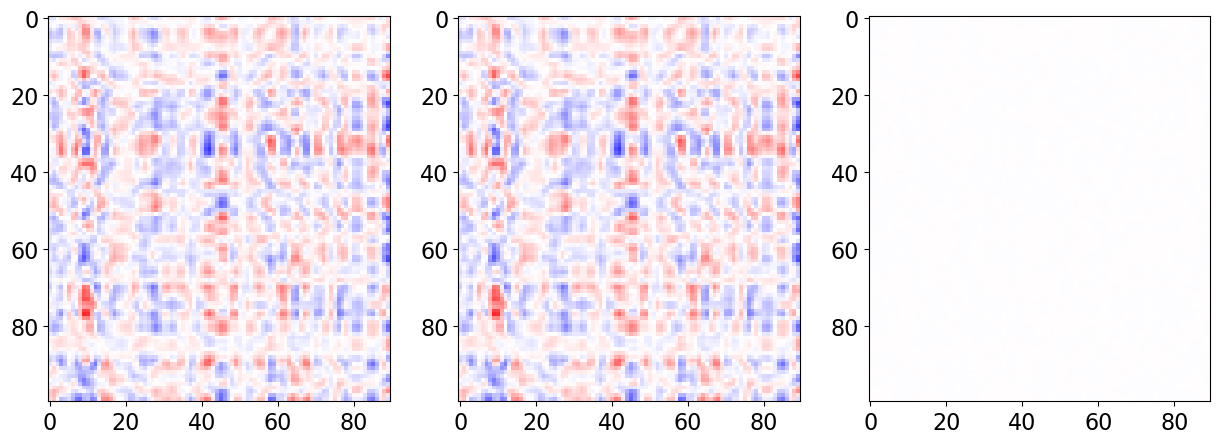

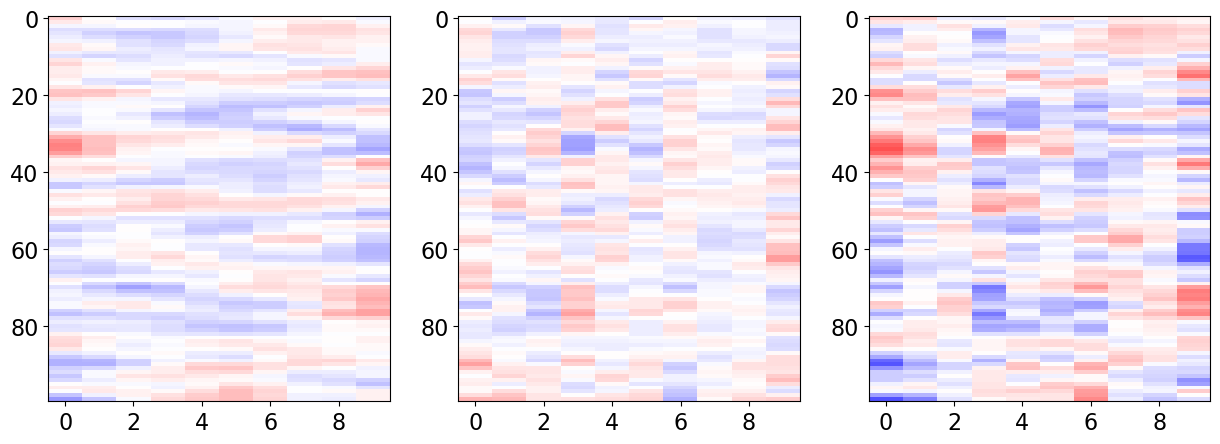

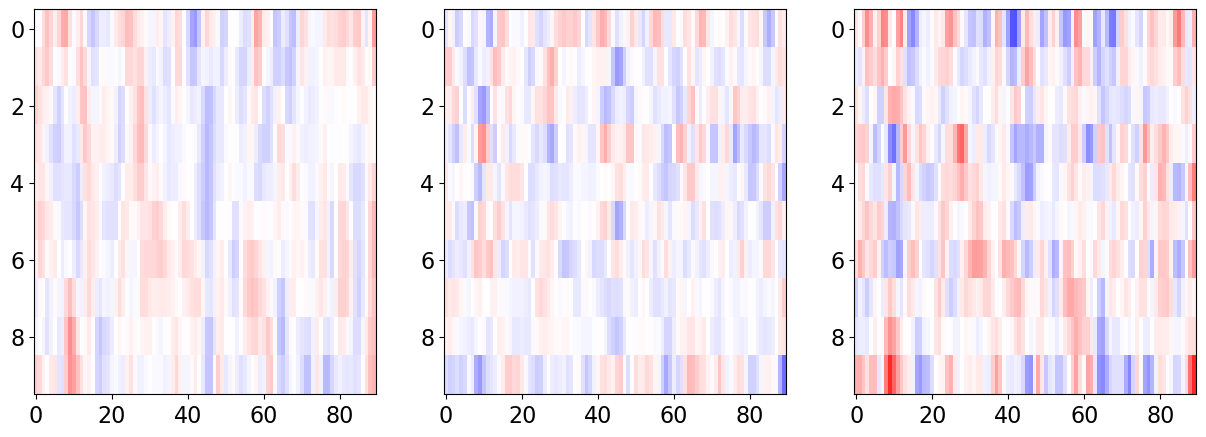

In [8]:
# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = GeneralizedPALM(hop, [l2f, l2g], x0s=[Xin.ravel(), Yin.ravel()], 
                        gammafs=[2, 2], niter=500, acceleration='fista', show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = None	niter = 400

   Itn      x[0][0]        f0      f1      H
     0    2.06746e-01   7.49e+00   3.01e+01   2.72930e+03
     1    7.19954e-02   4.94e+00   2.78e+01   1.13965e+03
     2    3.96600e-02   4.32e+00   2.71e+01   8.02754e+02
     3    3.61408e-02   4.12e+00   2.68e+01   6.78867e+02
     4    4.08307e-02   4.05e+00   2.67e+01   6.08582e+02
     5    4.78701e-02   4.04e+00   2.66e+01   5.53075e+02
     6    5.57340e-02   4.07e+00   2.66e+01   5.00922e+02
     7    6.41334e-02   4.13e+00   2.67e+01   4.49327e+02
     8    7.30079e-02   4.19e+00   2.67e+01   3.99050e+02
     9    8.21800e-02   4.26e+00   2.68e+01   3.52257e+02
    40    1.93593e-01   4.73e+00   2.55e+01   6.53264e+01
    80    3.07988e-01 

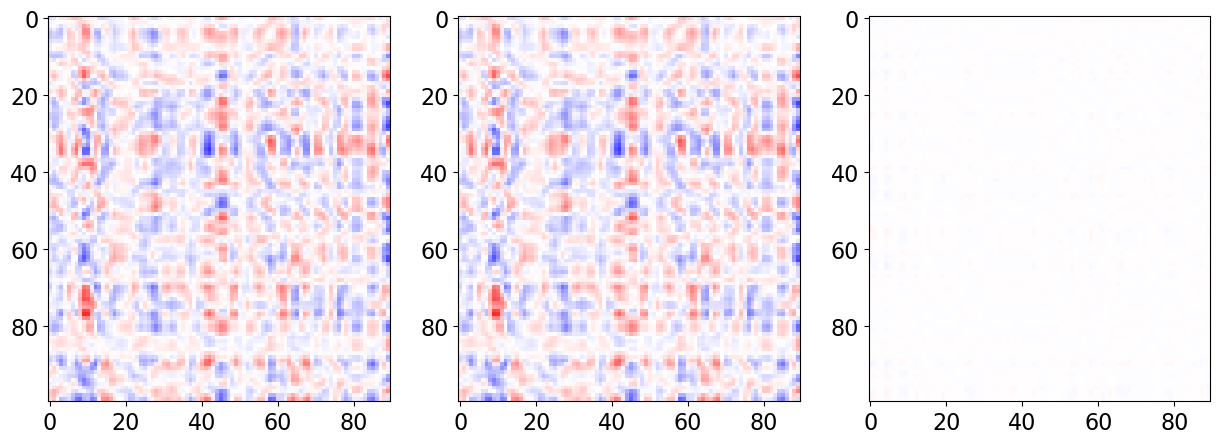

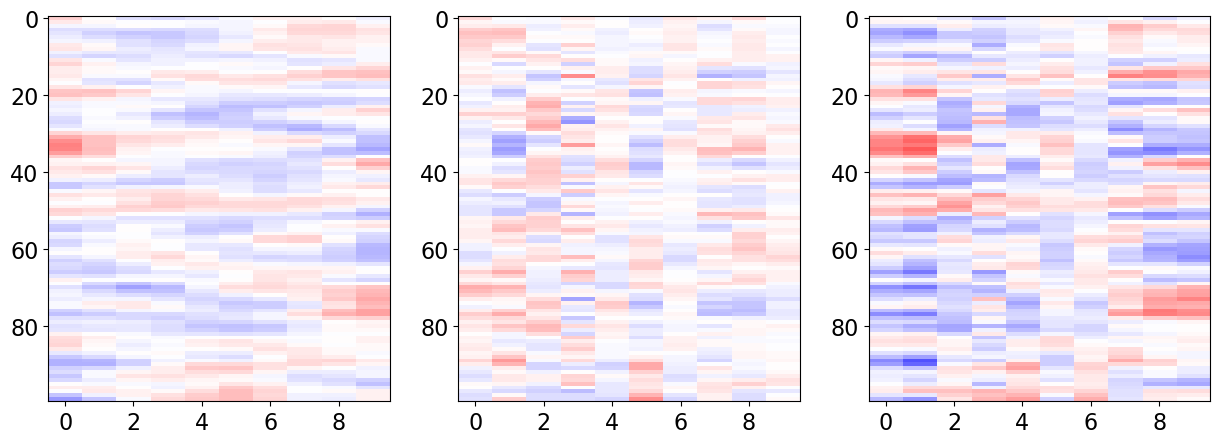

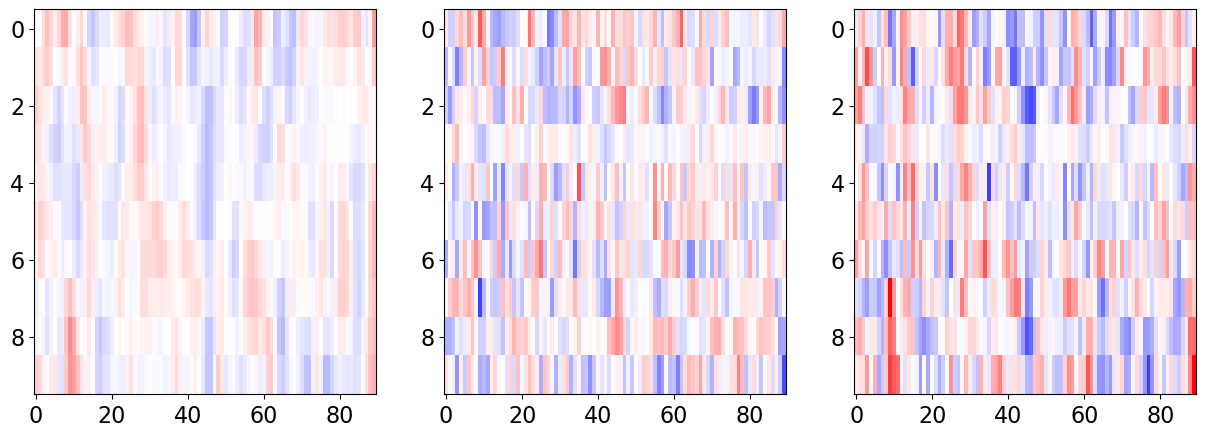

In [9]:
# Using back-tracking

# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = GeneralizedPALM(hop, [l2f, l2g], x0s=[Xin.ravel(), Yin.ravel()], 
                        gammafs=None, niter=400, niterback=100, beta=0.5,
                        acceleration=None, show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
gammaf = 2	gammag = 2	niter = 500

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  1.13774e+00  1.35e-01  3.57e+01  3.07e+01  2.07e+04  5.55e+02  4.82e+02
     2  9.59118e-01  1.20e-01  2.69e+01  2.37e+01  1.10e+04  4.18e+02  3.74e+02
     3  8.22428e-01  1.13e-01  2.13e+01  1.92e+01  6.18e+03  3.36e+02  3.10e+02
     4  7.18298e-01  1.11e-01  1.77e+01  1.64e+01  3.76e+03  2.87e+02  2.72e+02
     5  6.38813e-01  1.12e-01  1.55e+01  1.46e+01  2.49e+03  2.60e+02  2.51e+02
     6  5.77359e-01  1.15e-01  1.41e+01  1.35e+01  1.80e+03  2.44e+02  2.38e+02
     7  5.28853e-01  1.19e-01  1.32e+01  1.28e+01  1.40e+03  2.35e+02  2.31e+02
     8  4.89617e-01  1.25e-01  1.26e+01  1.23e+01  1.16e

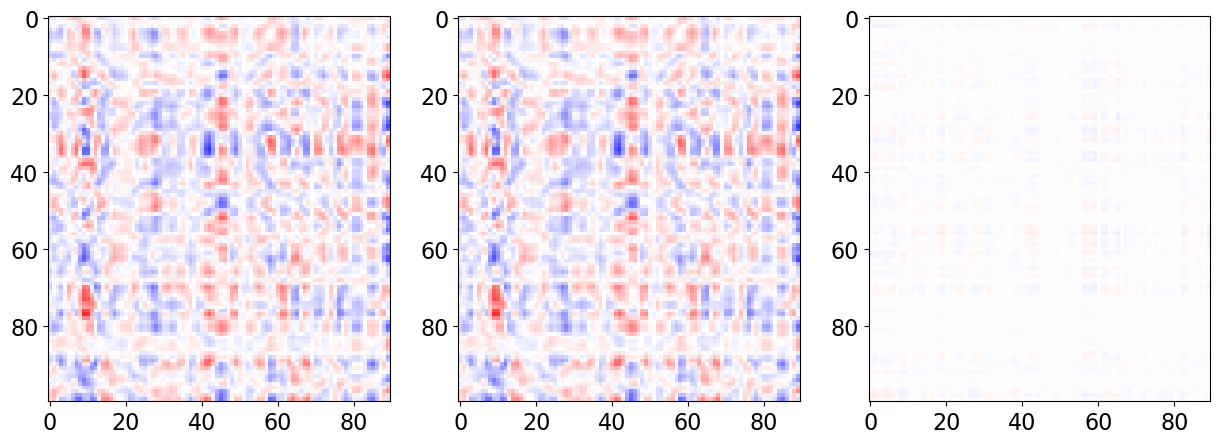

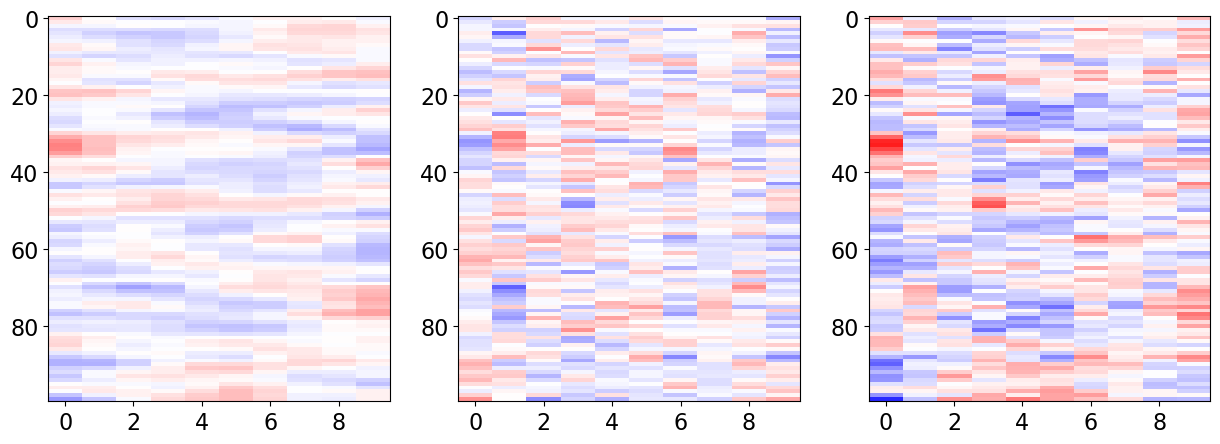

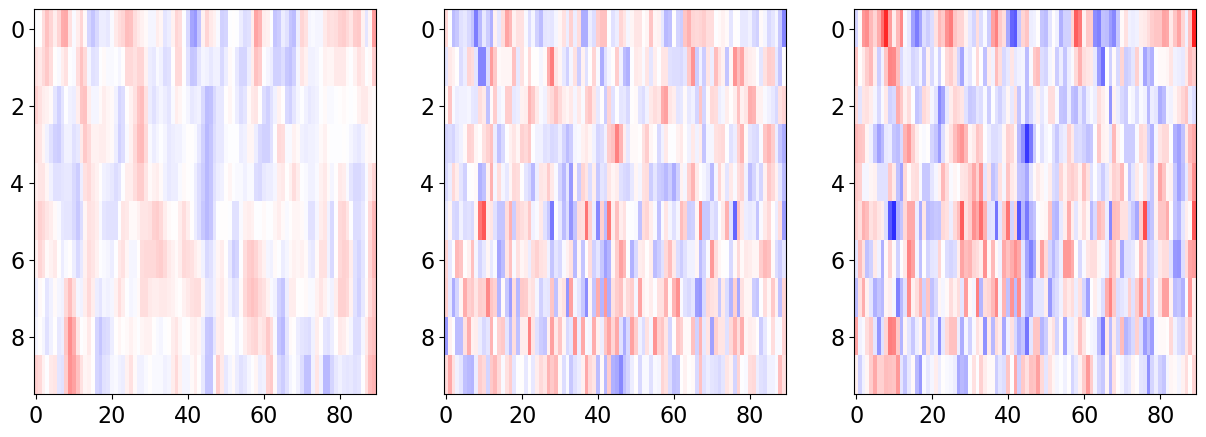

In [10]:
# easy, close to X and Y (PALM)
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = pyproxLowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = PALM(hop, l2f, l2g, x0=Xin.ravel(), y0=Yin.ravel(), 
             gammaf=2, gammag=2, niter=500,  show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
gammaf = None	gammag = None	niter = 500

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  4.62834e-01  -1.39e+00  7.18e+00  3.95e+01  4.49e+03  0.00e+00  0.00e+00
     2  2.13334e-01  -1.38e+00  2.99e+00  3.78e+01  1.52e+03  0.00e+00  0.00e+00
     3  1.15504e-01  -1.37e+00  1.88e+00  3.71e+01  1.04e+03  0.00e+00  0.00e+00
     4  6.63298e-02  -1.36e+00  1.39e+00  3.68e+01  8.60e+02  0.00e+00  0.00e+00
     5  3.99324e-02  -1.35e+00  1.13e+00  3.65e+01  7.74e+02  0.00e+00  0.00e+00
     6  2.49470e-02  -1.34e+00  9.84e-01  3.64e+01  7.24e+02  0.00e+00  0.00e+00
     7  1.58357e-02  -1.34e+00  8.95e-01  3.62e+01  6.92e+02  0.00e+00  0.00e+00
     8  9.79243e-03  -1.33e+00  8.42e-01  3

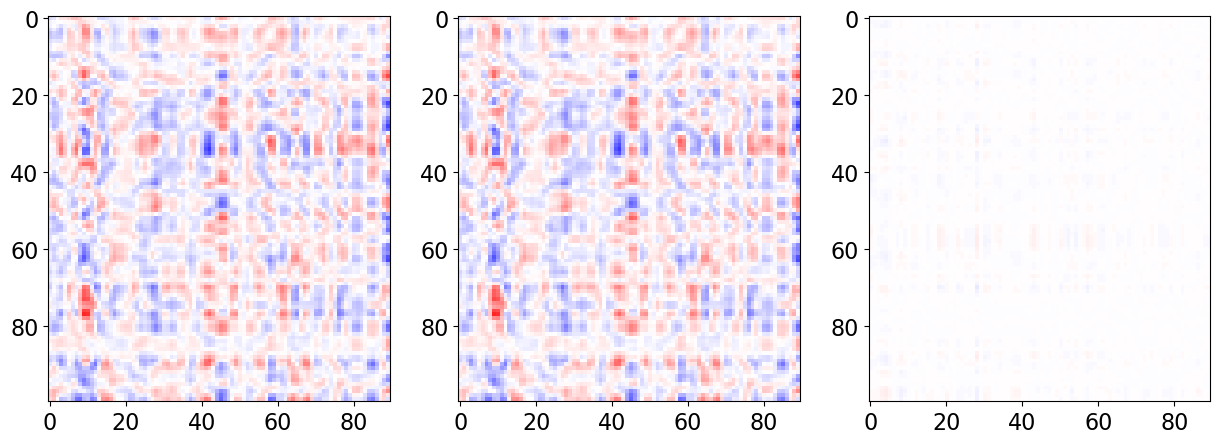

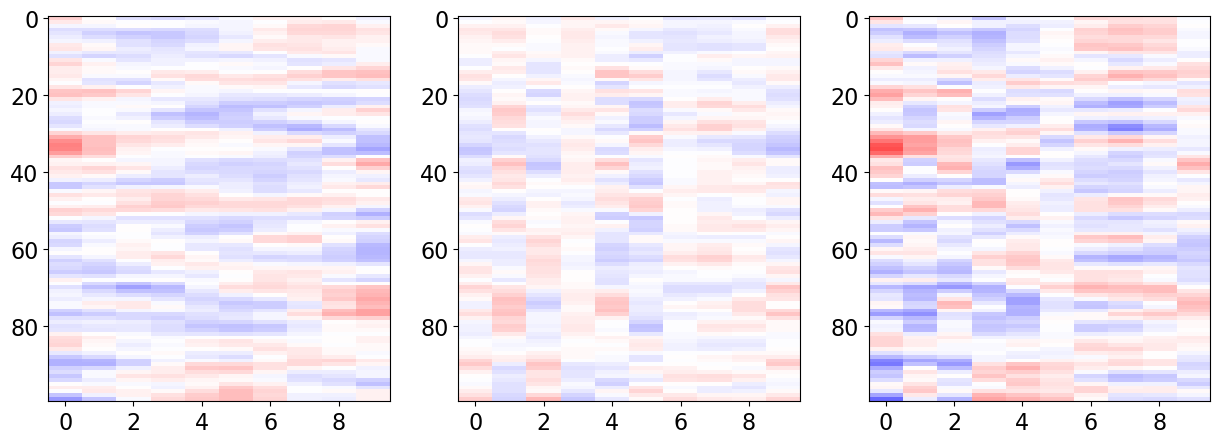

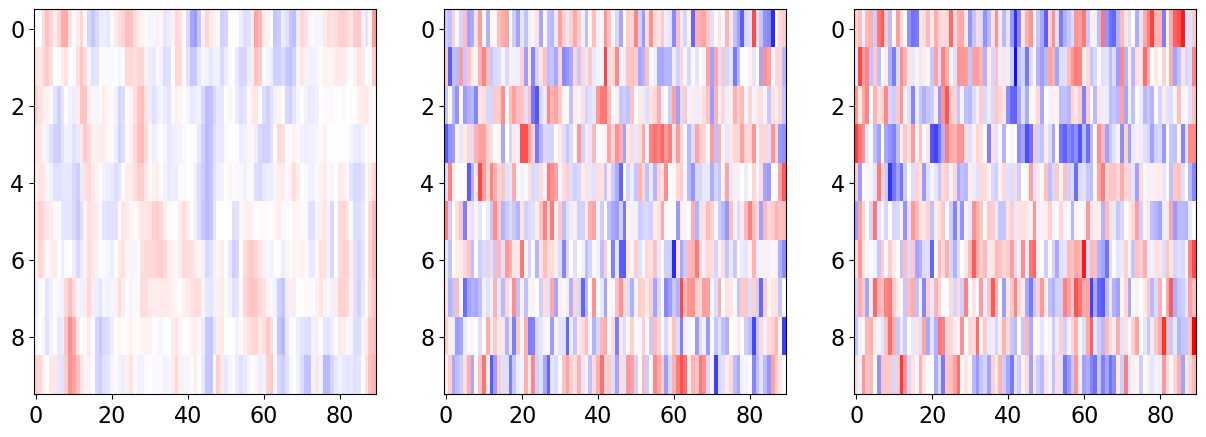

In [11]:
# Using back-tracking

# easy, close to X and Y (PALM)
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sigma = 0.1
hop = pyproxLowRankFactorizedMatrix(Xin.copy(), Yin.copy(), A.ravel())
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = PALM(hop, l2f, l2g, x0=Xin.ravel(), y0=Yin.ravel(), 
             gammaf=None, gammag=None, niter=500,  show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = None	niter = 5000

   Itn      x[0][0]        f0      f1      H
     0    1.08682e+00   3.09e+01   2.58e+01   1.24751e+03
     1    9.79376e-01   2.76e+01   2.12e+01   6.10794e+02
     2    9.13135e-01   2.60e+01   1.87e+01   3.90856e+02
     3    8.65222e-01   2.50e+01   1.70e+01   2.84045e+02
     4    8.27633e-01   2.43e+01   1.59e+01   2.22593e+02
     5    7.96736e-01   2.38e+01   1.50e+01   1.83356e+02
     6    7.70502e-01   2.34e+01   1.44e+01   1.56451e+02
     7    7.47711e-01   2.31e+01   1.38e+01   1.37009e+02
     8    7.27573e-01   2.28e+01   1.34e+01   1.22381e+02
     9    7.09553e-01   2.25e+01   1.30e+01   1.11012e+02
   500    1.03180e-01   8.18e+00   4.89e+00   3.15174e+00
  1000    1.09056e-01

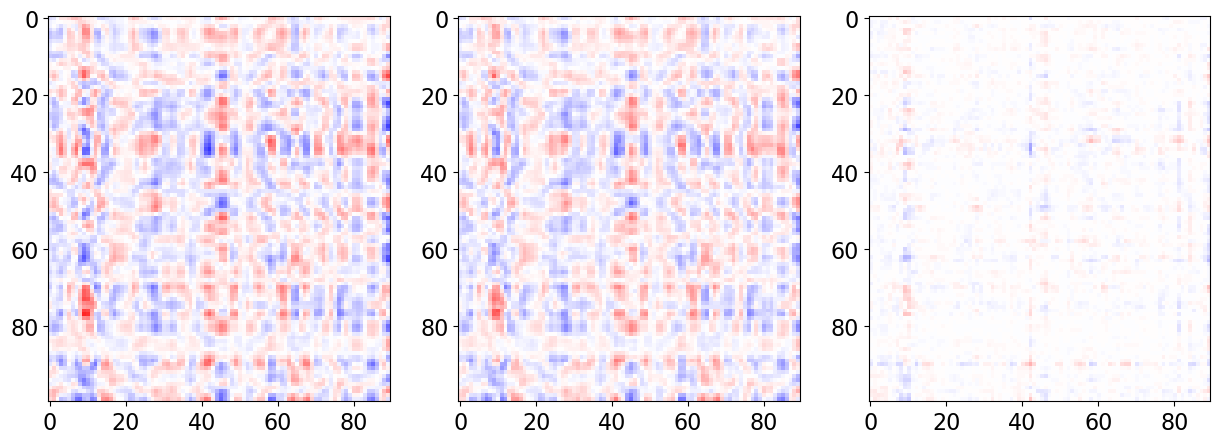

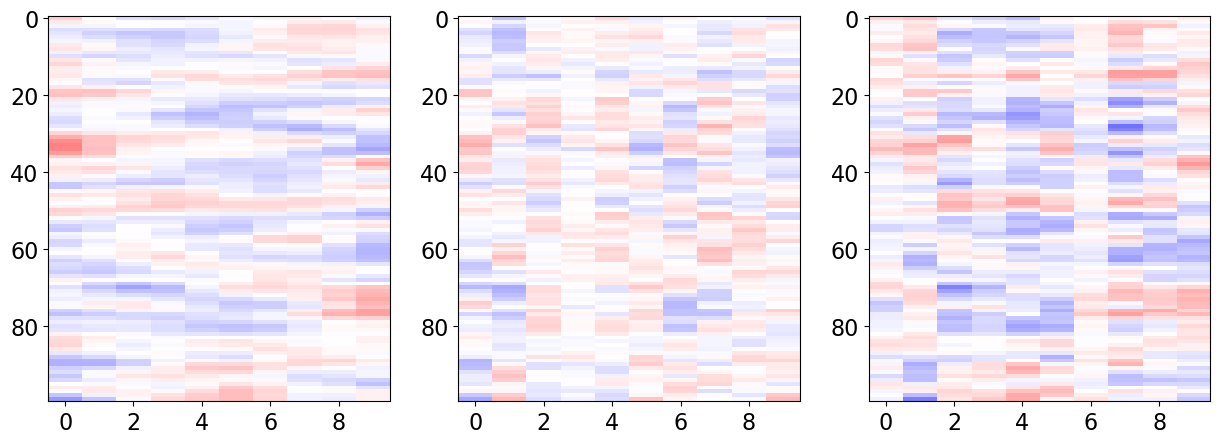

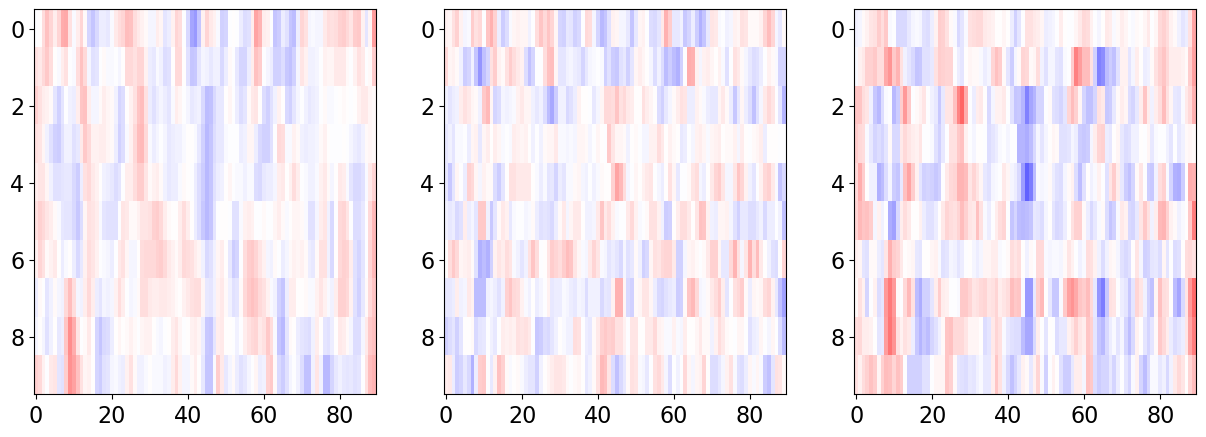

In [12]:
# Adding ROp and using back-tracking

# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sub = 0.2
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

sigma = 0.1
hop = LowRankFactorizedMatrix([Xin.copy(), Yin.copy()], Rop @ A.ravel(), Rop)
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = GeneralizedPALM(hop, [l2f, l2g], x0s=[Xin.ravel(), Yin.ravel()], 
                        gammafs=None, niter=5000, niterback=100, beta=0.5,
                        acceleration=None, show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

PALM algorithm
---------------------------------------------------------
Bilinear operator: <class 'pyproximal.utils.bilinear.LowRankFactorizedMatrix'>
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
gammaf = None	gammag = None	niter = 5000

   Itn      x[0]       y[0]        f         g         H         ck         dk
     1  4.00967e-01  -8.82e-01  3.05e+01  3.53e+01  2.17e+03  0.00e+00  0.00e+00
     2  2.75085e-01  -9.58e-01  2.48e+01  3.16e+01  1.05e+03  0.00e+00  0.00e+00
     3  2.26202e-01  -1.01e+00  2.20e+01  2.95e+01  6.54e+02  0.00e+00  0.00e+00
     4  2.05139e-01  -1.04e+00  2.03e+01  2.81e+01  4.64e+02  0.00e+00  0.00e+00
     5  1.96124e-01  -1.07e+00  1.92e+01  2.71e+01  3.56e+02  0.00e+00  0.00e+00
     6  1.92710e-01  -1.09e+00  1.83e+01  2.63e+01  2.88e+02  0.00e+00  0.00e+00
     7  1.91950e-01  -1.11e+00  1.77e+01  2.57e+01  2.42e+02  0.00e+00  0.00e+00
     8  1.92416e-01  -1.12e+00  1.71e+01  

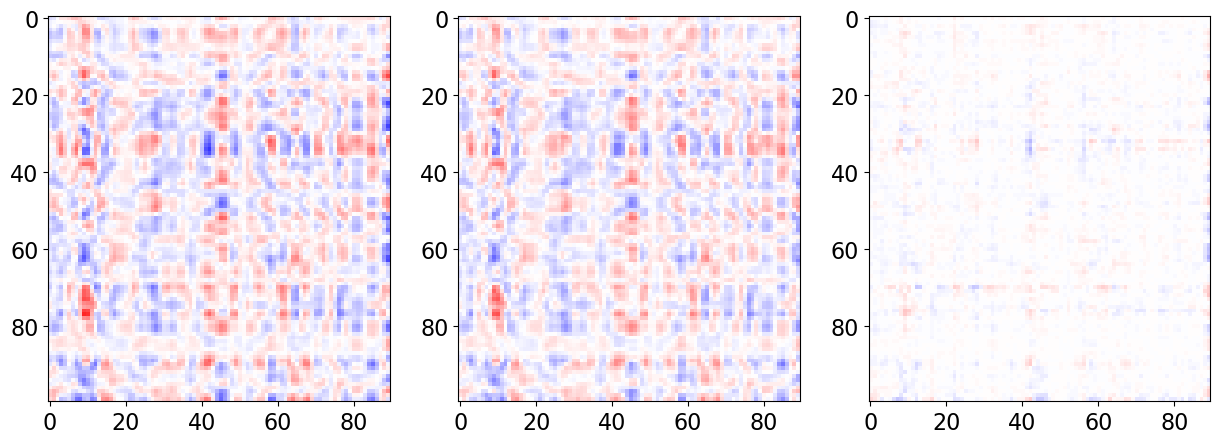

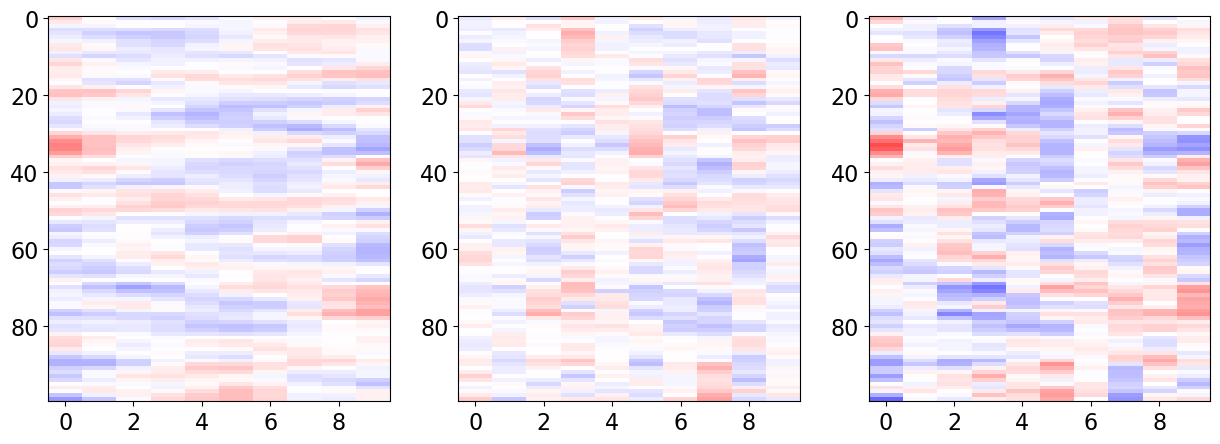

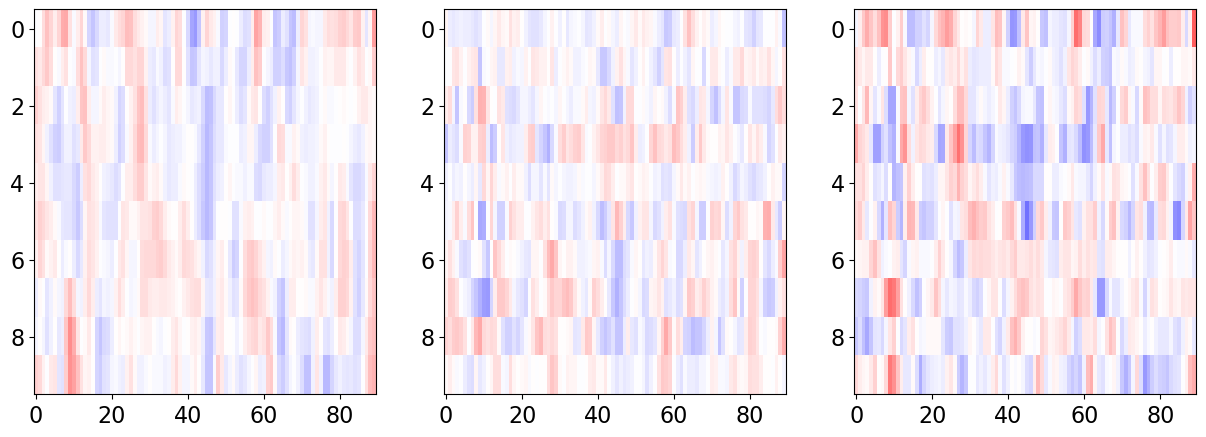

In [13]:
# Adding ROp and using back-tracking

# easy, close to X and Y
#Xin = np.random.normal(0, 0.2, (n, k)) + X
#Yin = np.random.normal(0, 0.2, (k, m)) + Y

# hard, random
Xin = np.random.normal(0, 1, (n, k))
Yin = np.random.normal(0, 1, (k, m))

sub = 0.2
nsub = int(n*m*sub)
iava = np.random.permutation(np.arange(n*m))[:nsub]
Rop = Restriction(n*m, iava)

sigma = 0.1
hop = pyproxLowRankFactorizedMatrix(Xin.copy(), Yin.copy(), Rop @ A.ravel(), Rop)
l2f = L2(sigma=sigma)
l2g = L2(sigma=sigma)

xsest = PALM(hop, l2f, l2g, x0=Xin.ravel(), y0=Yin.ravel(), 
             gammaf=None, gammag=None, niter=5000, show=True)
xest, yest = xsest[0], xsest[1]
Xest, Yest = xest.reshape(n, k), yest.reshape(k, m)
Aest = Xest @ Yest

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(A, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Aest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(A-Aest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(X, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Xest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(X-Xest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Y, vmin=-5, vmax=5, cmap='seismic')
axs[0].axis('tight')
axs[1].imshow(Yest, vmin=-5, vmax=5, cmap='seismic')
axs[1].axis('tight')
axs[2].imshow(Y-Yest, vmin=-5, vmax=5, cmap='seismic')
axs[2].axis('tight');

In [14]:
# FUQIANG EXAMPLE
np.random.seed(5)

ns, nr, nk = 111, 101, 101//10
d = np.random.rand(ns, nr) + np.random.rand(ns, nr)*1j

l_t = np.random.rand(nr, nk) + np.random.rand(nr, nk)*1j
r_t = np.random.rand(nk, nr) + np.random.rand(nk, nr)*1j

u = d.dot(l_t).dot(r_t).ravel()

l0 = np.random.rand(nr*nk) + np.random.rand(nr*nk)*1j
r0 = np.random.rand(nk*nr) + np.random.rand(nk*nr)*1j

D = MatrixMult(d, otherdims = (nr,))
Hop = LowRankFactorizedMatrix([l0.reshape(nr, nk), r0.reshape(nk, nr)], u, Op=D)
l2f = L2(sigma=0.2)
l2g = L2(sigma=0.2)

ret = GeneralizedPALM(Hop, [l2f, l2g], x0s=[l0, r0], 
                      gammafs=None, niter=400, niterback=100, beta=0.5,
                      acceleration='vandenberghe', show=True)

Generalized PALM algorithm
---------------------------------------------------------
Bilinear operator: <class '__main__.LowRankFactorizedMatrix'>
Proximal operator (f0): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (f1): <class 'pyproximal.proximal.L2.L2'>
gammafs = None	niter = 400

   Itn      x[0][0]        f0      f1      H
     0    1.90954e-01   6.70e+01   8.62e+01   1.20356e+08
     1    1.79155e-02   3.84e+01   1.54e+02   3.19320e+06
     2    3.53773e-03   3.63e+01   1.55e+02   3.81865e+05
     3    5.88922e-03   3.64e+01   1.55e+02   3.48334e+05
     4    6.74881e-03   3.64e+01   1.55e+02   3.40899e+05
     5    7.30370e-03   3.64e+01   1.55e+02   3.33773e+05
     6    7.69511e-03   3.63e+01   1.55e+02   3.26117e+05
     7    8.00231e-03   3.63e+01   1.54e+02   3.17931e+05
     8    8.25712e-03   3.63e+01   1.54e+02   3.09276e+05
     9    8.47670e-03   3.63e+01   1.54e+02   3.00216e+05
    40    6.89116e-03   3.54e+01   1.51e+02   8.46591e+04
    80    6.36181e-03 

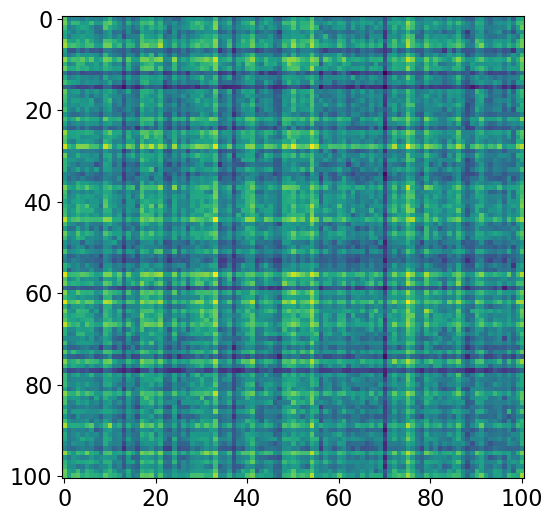

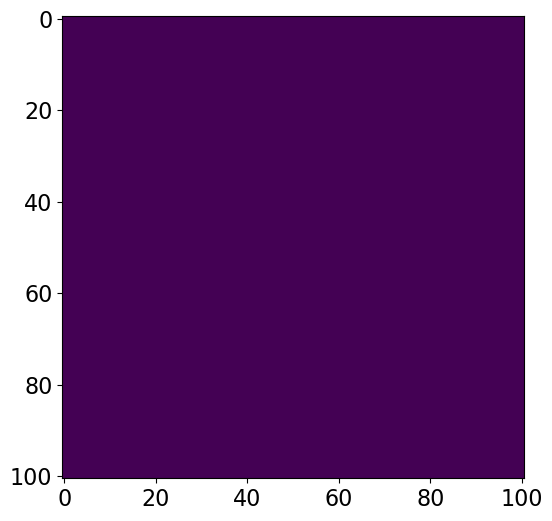

In [15]:
ret_prod = np.abs(ret[0].reshape(nr, nk).dot(ret[1].reshape(nk, nr)))
xtrue = np.abs(l_t.dot(r_t))

plt.figure()
plt.imshow(xtrue, vmin=np.min(xtrue), vmax=np.max(xtrue))

plt.figure()
plt.imshow(ret_prod-xtrue, vmin=np.min(xtrue)*1, vmax=np.max(xtrue)*1)

In [37]:
import pytest

import numpy as np
from numpy.testing import assert_array_almost_equal
from pylops.basicoperators import Identity
from pyproximal.utils import moreau
from pyproximal.proximal import Box, EuclideanBall, L0Ball, L01Ball, L1Ball, \
    NuclearBall, Simplex, AffineSet, Hankel

par1 = {'nx': 10, 'ny': 8, 'axis': 0, 'dtype': 'float32'}  # even float32 dir0
par2 = {'nx': 11, 'ny': 8, 'axis': 1, 'dtype': 'float64'}  # odd float64 dir1
par3 = {'nx': 10, 'ny': 8, 'axis': 0, 'dtype': 'float32'}  # even float32 dir0
par4 = {'nx': 11, 'ny': 8, 'axis': 1, 'dtype': 'float64'}  # odd float64  dir1

par = par2

"""Euclidean Ball projection and proximal/dual proximal of related indicator
"""
np.random.seed(10)

eucl = EuclideanBall(np.zeros(par['nx']), 1.)
x = np.random.normal(0., 1., par['nx']).astype(par['dtype']) + 1.

# evaluation
assert eucl(x) == False
xp = eucl.prox(x, 1.)
assert eucl(xp) == True

# prox / dualprox
tau = 2.
assert moreau(eucl, x, tau)
